In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from astropy.table import QTable
from astropy import units as u
from astropy import constants as const
import numpy as np
from matplotlib import pyplot as plt

from cluster import Cluster
from load_mcxc_data import load_clusters

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [30]:
mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())
mcxccls = mcxccls.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_23134/2385452468.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())


In [34]:
mcxccls.columns=mcxccls.columns.str.strip()
mcxccls.columns.tolist()

['MCXC',
 'OName',
 'AName',
 'Ah Am  RAs  Ed Em Es',
 'RAdeg   DEdeg',
 'GLON    GLAT',
 'z',
 'Cat',
 'Sub-Cat',
 'Scale',
 'L500',
 'M500',
 'R500',
 'Notes',
 'Cat1',
 'Cat2',
 'Cat3',
 'Cat4',
 '500r1',
 '500r2',
 '500r3',
 '500r4']

In [35]:
mcxccls['M500']

0       0.7373
1       0.3297
2       1.6557
3       2.6927
4       5.2188
         ...  
1738    2.6658
1739    1.9699
1740    0.7568
1741    1.4784
1742    2.1579
Name: M500, Length: 1743, dtype: float64

In [36]:
mcxccls['M500'].min(), mcxccls['M500'].max()

(0.0096, 22.1)

In [37]:
mcxccls['L500'].min(), mcxccls['L500'].max()

(0.000153, 37.304424)

In [38]:
mcxccls['R500'].min(), mcxccls['R500'].max()

(0.1497, 1.69)

In [39]:
cls_data={'M500':mcxccls['M500'],
          'L500':mcxccls['L500'],
          'R500':mcxccls['R500']
         }
units={
    'M500': 1e14*u.Msun,
    'L500': 1e37*u.W,
    'R500':u.Mpc
}

In [40]:
cls_table=QTable(cls_data, units=units)

In [41]:
cls_table

M500,L500,R500
1e+14 solMass,1e+37 W,Mpc
float64,float64,float64
0.7373,0.19628,0.6296
0.3297,0.052338,0.4817
1.6557,0.814902,0.8021
2.6927,1.990205,0.9178
5.2188,6.107094,1.1326
1.2016,0.441862,0.7388
...,...,...
2.1719,1.307553,0.871


In [42]:
i=1
test_cluster=Cluster(cls_table['R500'][i], cls_table['M500'][i], L500=cls_table['L500'][i], m500=cls_table['M500'][i])

In [43]:
test_cluster.mass

<Quantity 3.677527e+70 GeV>

In [44]:
test_cluster.baryon_temp

<Quantity 9.23082525e-07 GeV>

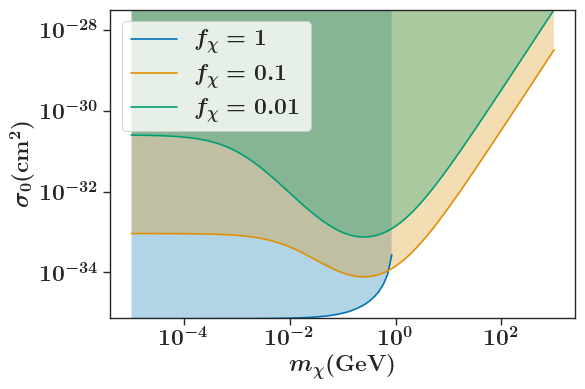

In [45]:
test_cluster.plot_sigma0_vs_m_chi(f_chi=[1, 0.1, 0.01], n=[-4], region=True, minimal=True, fontsize='xx-large')

In [46]:
cls_table['M500'].min(), cls_table['M500'].max()

(<Quantity 0.0096 1e+14 solMass>, <Quantity 22.1 1e+14 solMass>)

In [47]:
cls_table['L500'].min(), cls_table['L500'].max()

(<Quantity 0.000153 1e+37 W>, <Quantity 37.304424 1e+37 W>)

In [48]:
from cluster import temp_from_luminosity
temp_from_luminosity(cls_table['L500'].min()), temp_from_luminosity(cls_table['L500'].max())

(<Quantity 1.21712666e-07 GeV>, <Quantity 9.03328708e-06 GeV>)

In [49]:
temp_from_luminosity(cls_table['L500'].min()).to(u.K, equivalencies=u.temperature_energy()),temp_from_luminosity(cls_table['L500'].max()).to(u.K, equivalencies=u.temperature_energy())


(<Quantity 1412416.83704192 K>, <Quantity 1.04826944e+08 K>)

In [50]:
cls_table['R500'].min(), cls_table['R500'].max()

(<Quantity 0.1497 Mpc>, <Quantity 1.69 Mpc>)

In [51]:
# sanity check
m_chi=0.1*u.GeV
n_dm = test_cluster.rho_dm/m_chi
sigma_0 = 1e-24*u.cm**2
v = (const.G*test_cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(test_cluster.radius).to(u.m))**(1/2)
n_dm, sigma_0, v

(<Quantity 0.0240618 1 / cm3>,
 <Quantity 1.e-24 cm2>,
 <Quantity 542564.90021259 m / s>)

In [52]:
test_cluster.rho_dm

<Quantity 0.00240618 GeV / cm3>

In [53]:
interaction_rate = (n_dm*sigma_0*v).to(1/u.Gyr)
interaction_rate, 1/interaction_rate

(<Quantity 0.04119873 1 / Gyr>, <Quantity 24.27259128 Gyr>)

In [54]:
m_chi=1000*u.GeV
n_dm = test_cluster.rho_dm/m_chi
sigma_0 = 1e-19*u.cm**2
v = (const.G*test_cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(test_cluster.radius).to(u.m))**(1/2)
n_dm, sigma_0, v

(<Quantity 2.40618046e-06 1 / cm3>,
 <Quantity 1.e-19 cm2>,
 <Quantity 542564.90021259 m / s>)

In [55]:
interaction_rate = (n_dm*sigma_0*v).to(1/u.Gyr)
interaction_rate, 1/interaction_rate
# but this is out of range because the 1-comp DM is only valid for m_chi<1GeV

(<Quantity 0.41198733 1 / Gyr>, <Quantity 2.42725913 Gyr>)

In [56]:
# alternatively, make some of the DM non-interacting
m_chi=0.1*u.GeV
fx = 0.1
rho_chi = test_cluster.rho_dm/m_chi * fx
n_chi = rho_chi/m_chi
sigma_0 = 1e-19*u.cm**2
v = (const.G*test_cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(test_cluster.radius).to(u.m))**(1/2)
n_dm, sigma_0, v

(<Quantity 2.40618046e-06 1 / cm3>,
 <Quantity 1.e-19 cm2>,
 <Quantity 542564.90021259 m / s>)

In [57]:
interaction_rate = (n_dm*sigma_0*v).to(1/u.Gyr)
interaction_rate, 1/interaction_rate
# now we are in range

(<Quantity 0.41198733 1 / Gyr>, <Quantity 2.42725913 Gyr>)

In [58]:
def interaction_time(m_chi, f_chi, cluster):
    rho_chi = cluster.rho_dm * f_chi
    n_chi = rho_chi/m_chi # number density of IDM
    v = (const.G*cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(cluster.radius).to(u.m))**(1/2)
    sigma_0 = s0(cluster, m_chi, f_chi=f_chi)
    interaction_rate = (n_chi*sigma_0*v).to(1/u.Gyr)
    return 1/interaction_rate
    

In [59]:
interaction_time(100*u.GeV, 0.01, test_cluster)

NameError: name 's0' is not defined

In [60]:
from cluster import c
# function to return sigma_0 for a single m_chi
def s0(cluster, m_chi, f_chi=1, m_psi=0.01 * u.GeV, n=0):
    dm_temp = cluster.virial_temperature(m_chi, f_chi=f_chi, m_psi=m_psi)
    uth = np.sqrt(cluster.baryon_temp / cluster.m_b + dm_temp / m_chi)
    rho_chi = cluster.rho_dm * f_chi
    total_heating_rate = cluster.radiative_cooling_rate()
    numerator = total_heating_rate * (m_chi + cluster.m_b) ** 2
    denominator = (
        3
        * (cluster.baryon_temp - dm_temp)
        * rho_chi
        * cluster.rho_b
         * cluster.volume
         * c(n)
         * uth ** (n + 1)
         * const.c.to(u.cm / u.s)
     )
    sigma0 = (numerator / denominator).to(u.cm**2)
    return sigma0

    


In [61]:
s0(test_cluster, 0.1*u.GeV, f_chi=0.1)

<Quantity 3.81641921e-24 cm2>

In [62]:
n=1000
fxs = np.logspace(-4, 0, n)
mxs = np.logspace(-6, 3, n)

m, f = np.meshgrid(mxs, fxs)

int_time = np.zeros((n,n)) * u.Gyr
int_time_above_1Gyr = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        int_time[i, j] = interaction_time(m[i, j]*u.GeV, f[i, j], test_cluster)
        int_time_above_1Gyr[i, j] = 1 if int_time[i,j].value >= 1 else 0


In [63]:
int_time

<Quantity [[ 5.25868979e-02,  5.34071094e-02,  5.42371984e-02, ...,
             6.77800221e-01,  6.63911321e-01,  6.50306486e-01],
           [ 5.24668763e-02,  5.32864897e-02,  5.41159972e-02, ...,
             6.77800214e-01,  6.63911314e-01,  6.50306480e-01],
           [ 5.23465725e-02,  5.31655778e-02,  5.39944938e-02, ...,
             6.77800207e-01,  6.63911307e-01,  6.50306473e-01],
           ...,
           [ 1.06245984e-03,  1.08472962e-03,  1.10746618e-03, ...,
             2.86234076e-01,  2.80362713e-01,  2.74611684e-01],
           [ 1.05999866e-03,  1.08221686e-03,  1.10490076e-03, ...,
            -1.08736923e-01, -1.06525508e-01, -1.04358644e-01],
           [ 1.05755441e-03,  1.07972138e-03,  1.10235298e-03, ...,
            -9.88165894e+02, -9.88225425e+02, -9.88283737e+02]] Gyr>

In [64]:
int_time_above_1Gyr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, '$f_{\\chi}$')

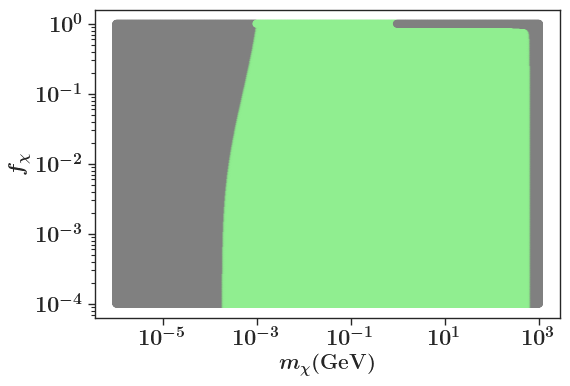

In [65]:
from matplotlib import colors
plt.scatter(m, f, c=int_time_above_1Gyr, cmap=colors.ListedColormap(['gray', 'lightgreen']))
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$m_{\chi} \mathrm{(GeV)}$', size=15)
plt.ylabel(r'$f_{\chi}$', size=15)



In [66]:
#from matplotlib.patches import Patch
#legend_elements = [Patch(facecolor='gray',label=r'$T_{\chi}>T_b$'), 
#                   Patch(facecolor='lightgreen',label=r'$T_{\chi}<T_b$')]
#ax.legend(handles=legend_elements, loc='lower left')


In [69]:
from load_mcxc_data import load_clusters
clusters, variance = load_clusters()

/Users/eleanorstuart/Desktop/krisp/thermo-idm/load_mcxc_data.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter, nrows=nrows)


Text(0.5, 0, 'cluster mass ($10^{14}$ Msun)')

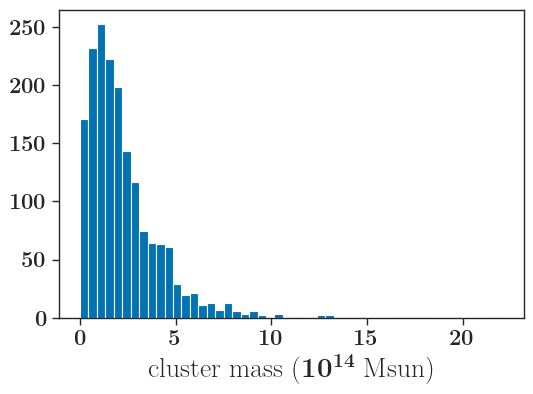

In [87]:
masses = [c.mass.to(1e14*u.Msun) for c in clusters]
plt.hist(masses, bins=50)
plt.xlabel('cluster mass ($10^{14}$ Msun)')

Text(0.5, 0, 'cluster luminosity ($10^{37}$ W)')

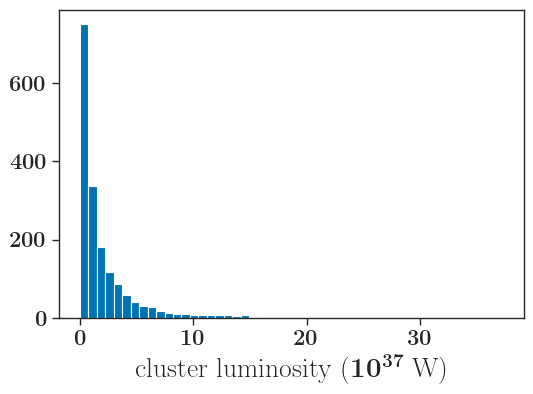

In [88]:
luminosities = [c.L500.to(1e37*u.W) for c in clusters]
plt.hist(luminosities, bins=50)
plt.xlabel('cluster luminosity ($10^{37}$ W)')

Text(0.5, 0, 'cluster temperature ($10^{-6}$ GeV)')

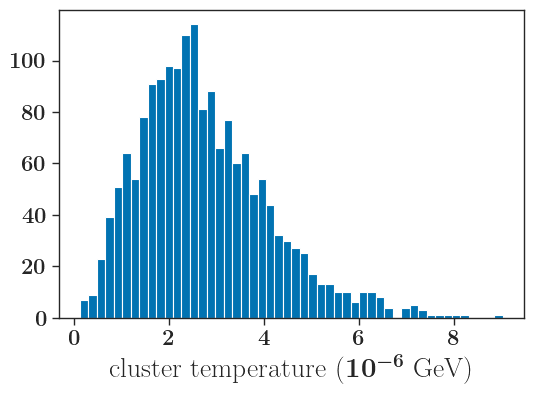

In [90]:
temperatures=[c.baryon_temp.to(1e-6*u.GeV) for c in clusters]
plt.hist(temperatures, bins=50)
plt.xlabel('cluster temperature ($10^{-6}$ GeV)')

In [ ]:
clusters, variances=load_clusters(nrows=20)

In [ ]:
variances

In [10]:
mcxccls

,MCXC,OName,AName,Ah Am RAs Ed Em Es,RAdeg DEdeg,GLON GLAT,z,Cat,Sub-Cat,Scale,...,R500,Notes,Cat1,Cat2,Cat3,Cat4,500r1,500r2,500r3,500r4
0,J0000.1+0816,RXC J0000.1+0816,UGC 12890 ...,0 0 7.1 + 8 16 28,0.030 8.274,101.783 -52.477,0.0396,NORAS/REFLEX,NORAS,0.784,...,0.6296,,BCS,,,,1.084,,,NaN
1,J0000.4-0237,RXC J0000.4-0237,...,0 0 24.7 - 2 37 30,0.103 -2.625,94.268 -62.622,0.0379,SGP,SGP,0.752,...,0.4817,,,,,,,,,NaN
2,J0001.6-1540,RXC J0001.6-1540,...,0 1 39.0 -15 40 52,0.412 -15.681,75.129 -73.733,0.1246,SGP,SGP,2.234,...,0.8021,,,,,,,,,NaN
3,J0001.9+1204,RXC J0001.9+1204,A2692 ...,0 1 57.0 +12 4 23,0.488 12.073,104.308 -49.001,0.2033,NORAS/REFLEX,NORAS,3.342,...,0.9178,,,,,,,,,NaN
4,J0003.1-0605,RXCJ0003.1-0605,A2697 ...,0 3 11.8 - 6 5 10,0.799 -6.086,92.169 -66.033,0.2320,NORAS/REFLEX,REFLEX,3.698,...,1.1326,,SGP,,,,0.952,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,J2357.0-3445,RXCJ2357.0-3445,A4059 ...,23 57 2.3 -34 45 38,359.260 -34.761,356.359 -76.082,0.0475,NORAS/REFLEX,REFLEX,0.931,...,0.9640,L,EMSS_1994,SGP,,,0.132,0.952,,NaN
1739,J2359.3-6042,RXCJ2359.3-6042,A4067 ...,23 59 19.2 -60 42 0,359.830 -60.700,314.102 -55.284,0.0989,NORAS/REFLEX,REFLEX,1.826,...,0.8572,,,,,,,,,NaN
1740,J2359.4-3418,MS2356.9-3434,...,23 59 27.3 -34 18 22,359.864 -34.306,357.005 -76.739,0.1150,EMSS,EMSS_1994,2.085,...,0.6198,,,,,,,,,NaN
1741,J2359.5-3211,RX J2359.5-3211,BSe RXJ2359.5-3211 ...,23 59 36.0 -32 11 6,359.900 -32.185,5.630 -77.667,0.4780,SHARC,SHARC_SOUTH,5.957,...,0.6776,,,,,,,,,NaN


In [11]:
mcxccls.columns=mcxccls.columns.str.strip()
mcxccls.columns.tolist()

['MCXC',
 'OName',
 'AName',
 'Ah Am  RAs  Ed Em Es',
 'RAdeg   DEdeg',
 'GLON    GLAT',
 'z',
 'Cat',
 'Sub-Cat',
 'Scale',
 'L500',
 'M500',
 'R500',
 'Notes',
 'Cat1',
 'Cat2',
 'Cat3',
 'Cat4',
 '500r1',
 '500r2',
 '500r3',
 '500r4']

In [28]:
mcxccls

,MCXC,OName,AName,Ah Am RAs Ed Em Es,RAdeg DEdeg,GLON GLAT,z,Cat,Sub-Cat,Scale,...,R500,Notes,Cat1,Cat2,Cat3,Cat4,500r1,500r2,500r3,500r4
0,J0000.1+0816,RXC J0000.1+0816,UGC 12890 ...,0 0 7.1 + 8 16 28,0.030 8.274,101.783 -52.477,0.0396,NORAS/REFLEX,NORAS,0.784,...,0.6296,,BCS,,,,1.084,,,NaN
1,J0000.4-0237,RXC J0000.4-0237,...,0 0 24.7 - 2 37 30,0.103 -2.625,94.268 -62.622,0.0379,SGP,SGP,0.752,...,0.4817,,,,,,,,,NaN
2,J0001.6-1540,RXC J0001.6-1540,...,0 1 39.0 -15 40 52,0.412 -15.681,75.129 -73.733,0.1246,SGP,SGP,2.234,...,0.8021,,,,,,,,,NaN
3,J0001.9+1204,RXC J0001.9+1204,A2692 ...,0 1 57.0 +12 4 23,0.488 12.073,104.308 -49.001,0.2033,NORAS/REFLEX,NORAS,3.342,...,0.9178,,,,,,,,,NaN
4,J0003.1-0605,RXCJ0003.1-0605,A2697 ...,0 3 11.8 - 6 5 10,0.799 -6.086,92.169 -66.033,0.2320,NORAS/REFLEX,REFLEX,3.698,...,1.1326,,SGP,,,,0.952,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,J2357.0-3445,RXCJ2357.0-3445,A4059 ...,23 57 2.3 -34 45 38,359.260 -34.761,356.359 -76.082,0.0475,NORAS/REFLEX,REFLEX,0.931,...,0.9640,L,EMSS_1994,SGP,,,0.132,0.952,,NaN
1739,J2359.3-6042,RXCJ2359.3-6042,A4067 ...,23 59 19.2 -60 42 0,359.830 -60.700,314.102 -55.284,0.0989,NORAS/REFLEX,REFLEX,1.826,...,0.8572,,,,,,,,,NaN
1740,J2359.4-3418,MS2356.9-3434,...,23 59 27.3 -34 18 22,359.864 -34.306,357.005 -76.739,0.1150,EMSS,EMSS_1994,2.085,...,0.6198,,,,,,,,,NaN
1741,J2359.5-3211,RX J2359.5-3211,BSe RXJ2359.5-3211 ...,23 59 36.0 -32 11 6,359.900 -32.185,5.630 -77.667,0.4780,SHARC,SHARC_SOUTH,5.957,...,0.6776,,,,,,,,,NaN


In [31]:
reflex_cls=mcxccls[mcxccls['Sub-Cat']=='REFLEX']
reflex_cls

,MCXC,OName,AName,Ah Am RAs Ed Em Es,RAdeg DEdeg,GLON GLAT,z,Cat,Sub-Cat,Scale,...,R500,Notes,Cat1,Cat2,Cat3,Cat4,500r1,500r2,500r3,500r4
4,J0003.1-0605,RXCJ0003.1-0605,A2697,0 3 11.8 - 6 5 10,0.799 -6.086,92.169 -66.033,0.2320,NORAS/REFLEX,REFLEX,3.698,...,1.1326,,SGP,,,,0.952,,,NaN
5,J0003.2-3555,RXCJ0003.2-3555,A2717,0 3 12.1 -35 55 38,0.801 -35.927,349.330 -76.490,0.0490,NORAS/REFLEX,REFLEX,0.959,...,0.7388,losStr,SGP,,,,0.886,,,NaN
6,J0003.8+0203,RXCJ0003.8+0203,A2700,0 3 50.6 + 2 3 48,0.961 2.063,99.610 -58.637,0.0924,NORAS/REFLEX,REFLEX,1.719,...,0.8233,,eBCS,SGP,,,0.920,0.922,,NaN
9,J0006.0-3443,RXCJ0006.0-3443,A2721,0 6 3.0 -34 43 27,1.513 -34.724,352.147 -77.668,0.1147,NORAS/REFLEX,REFLEX,2.080,...,0.9486,,SGP,,,,0.949,,,NaN
13,J0011.3-2851,RXCJ0011.3-2851,A2734,0 11 20.7 -28 51 18,2.836 -28.855,19.562 -80.986,0.0620,NORAS/REFLEX,REFLEX,1.195,...,0.8807,losStr,SGP,,,,0.914,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,J2351.6-2605,RXCJ2351.6-2605,A2667,23 51 40.7 -26 5 1,357.919 -26.084,34.017 -76.609,0.2264,NORAS/REFLEX,REFLEX,3.631,...,1.3031,X,SGP,,,,0.947,,,NaN
1733,J2354.2-1024,RXCJ2354.2-1024,A2670,23 54 13.4 -10 24 46,358.556 -10.413,81.334 -68.530,0.0765,NORAS/REFLEX,REFLEX,1.450,...,0.9113,"B,losStr",SGP,,,,0.914,,,NaN
1738,J2357.0-3445,RXCJ2357.0-3445,A4059,23 57 2.3 -34 45 38,359.260 -34.761,356.359 -76.082,0.0475,NORAS/REFLEX,REFLEX,0.931,...,0.9640,L,EMSS_1994,SGP,,,0.132,0.952,,NaN
1739,J2359.3-6042,RXCJ2359.3-6042,A4067,23 59 19.2 -60 42 0,359.830 -60.700,314.102 -55.284,0.0989,NORAS/REFLEX,REFLEX,1.826,...,0.8572,,,,,,,,,NaN


0       NORAS       
1       SGP         
2       SGP         
3       NORAS       
4       REFLEX      
            ...     
1738    REFLEX      
1739    REFLEX      
1740    EMSS_1994   
1741    SHARC_SOUTH 
1742    REFLEX      
Name: Sub-Cat     , Length: 1743, dtype: object